In [9]:
#I need to import some modules from python for CSRNG
using PyCall
@pyimport sys
@pyimport random

#this type will  collect the data from a particular round of encrypter
type roundData
    inp::String  #inp for that round
    key::String  #key for that round
    outp::String #outp after addK-SLayer-PLayer
end
undef_round = roundData("undef","undef","undef")

roundData("undef","undef","undef")

In [10]:
#first I'll create a dictionary representing S_box
#the dictionary will be same as given in the research paper
S_val = [bin(0xc,4), bin(0x5,4), bin(0x6,4), bin(0xb,4), bin(0x9,4), bin(0x0,4), bin(0xa,4), bin(0xd,4), bin(0x3,4),
    bin(0xe,4), bin(0xf,4), bin(0x8,4), bin(0x4,4), bin(0x7,4), bin(0x1,4), bin(0x2,4)]
S_box = Dict()
for i in range(0,16)
    S_box[bin(i,4)] = S_val[i+1]
end
println("The S_box: ")
for i in 0:15
    println(hex(i,1),"--->",hex(parse(Int,S_box[bin(i,4)],2),1))
end
println()
#now I'll create the Permutation to represent P_box from the research paper
P_val = [0,16,32,48,1,17,33,49,2,18,34,50,3,19,35,51,4,20,36,52,5,21,37,53,6,22,38,54,7,23,39,55,8,24,40,56,9,25,41,57,
10,26,42,58,11,27,43,59,12,28,44,60,13,29,45,61,14,30,46,62,15,31,47,63]
P_box = Dict()
for i in range(0,64)
    P_box[i] = P_val[i+1]
end
println("The P_box: ")
for i in 0:63
    println(i,"--->",P_box[i])
end
println()


###########needed for decryption
#i need the inverse of the S_box as invS_box
invS_box = Dict()
for i in 0:15
    t = bin(i,4)
    invS_box[S_box[t]] = t
end
println("The invS_box: ")
for i in 0:15
    println(hex(i,1),"--->",hex(parse(Int,invS_box[bin(i,4)],2),1))
end
println()
#also need an inverse P-box invP_box
invP_box = Dict()
for i in range(0,64)
    invP_box[P_box[i]] = i 
end
println("The invP_box: ")
for i in 0:63
    println(i,"--->",invP_box[i])
end

The S_box: 
0--->c
1--->5
2--->6
3--->b
4--->9
5--->0
6--->a
7--->d
8--->3
9--->e
a--->f
b--->8
c--->4
d--->7
e--->1
f--->2

The P_box: 
0--->0
1--->16
2--->32
3--->48
4--->1
5--->17
6--->33
7--->49
8--->2
9--->18
10--->34
11--->50
12--->3
13--->19
14--->35
15--->51
16--->4
17--->20
18--->36
19--->52
20--->5
21--->21
22--->37
23--->53
24--->6
25--->22
26--->38
27--->54
28--->7
29--->23
30--->39
31--->55
32--->8
33--->24
34--->40
35--->56
36--->9
37--->25
38--->41
39--->57
40--->10
41--->26
42--->42
43--->58
44--->11
45--->27
46--->43
47--->59
48--->12
49--->28
50--->44
51--->60
52--->13
53--->29
54--->45
55--->61
56--->14
57--->30
58--->46
59--->62
60--->15
61--->31
62--->47
63--->63

The invS_box: 
0--->5
1--->e
2--->f
3--->8
4--->c
5--->1
6--->2
7--->d
8--->b
9--->4
a--->6
b--->3
c--->0
d--->7
e--->9
f--->a

The invP_box: 
0--->0
1--->4
2--->8
3--->12
4--->16
5--->20
6--->24
7--->28
8--->32
9--->36
10--->40
11--->44
12--->48
13--->52
14--->56
15--->60
16--->1
17--->5
18--->9
19--->13

In [11]:
#function definitions to be used in the program 
"""
a very subtle point is the bit positioning starts from 0 form RHS in the paper but in implemetation in julia
the positioning will be done from 1 from LHS, so have to take care of conversion.
"""

#my definition of xor
function xor(binstr1,binstr2)
    l1 = length(binstr1)
    l2 = length(binstr2)
    if l1<l2
        bin(parse(Int128,binstr1,2)$parse(Int128,binstr2,2),l2) #Int128 to avoid overlflow
    else
        bin(parse(Int128,binstr1,2)$parse(Int128,binstr2,2),l1)
    end
end

#definition of the sboxLayer(state)
function sboxLayer(state)
    new_state = ""
    for i in 4:4:64
        new_nibble = S_box[state[i-3:i]]
        new_state = join([new_state,new_nibble]) #join appends the strings inside array
    end
    state = new_state
end

#definition of the pLayer(state)
function pLayer(state)
    l = length(state)
    newStateArray = fill('0',l)
    for i in 1:l
        newStateArray[P_box[l-i]+1] = state[l-i+1]
    end
    state = join(newStateArray)
end

#definition of the invP operation
function invP(state)
    l = length(state)
    newStateArray = fill('0',l)
    for i in 1:l
        newStateArray[invP_box[l-i]+1] = state[l-i+1]
    end
    state = join(newStateArray)
end

#now the defintion of the genKeys(K_initial)
# K is 80bits long
function keyUpdate(K,i)
    #first rortate by 61 bits to the left
    K_new = rotate_str(K, 61)
    #update the 4 left more bits as given
    K_l4 = S_box[K_new[1:4]]
    K_new = join([K_l4,K_new[5:end]])
    #do xor of K_new[20:16] from right hand side and round counter
    K_in = xor(K_new[61:65],bin(i,5))
    K_new = join([K_new[1:60],K_in,K_new[66:end]])
end

#generic function to rotate the strings
function rotate_str(str,i)
    newstr = ""
    newstr = join([newstr,str[(i+1)%Int(length(str)):end]])
    newstr = join([newstr,str[1:(i%Int(length(str)))]])
end

function genKeys(K_initial)
    k_array = fill("",32)
    k_array[1] = K_initial
    for i in 2:32
        k_array[i] = keyUpdate(k_array[i-1],i-1)
    end
    roundkeys = fill("",32)
    for i in 1:32
        roundkeys[i] = k_array[i][1:64]
    end
    roundkeys
end

#some interconversion functions
function bin2hex(binstr)
    hex(parse(Int128,binstr,2),16) #default length is 16 for hex string, if value greater than Int128 then error
end

function hex2bin(hexstr)
    bin(parse(Int128,hexstr,16),64) #default length is 64 bits for bin string
end

#function to calculate HW of string
function HW(binstr)
    hw = 0
    for i in 1:length(binstr)
        if binstr[i] == '1'
            hw = hw+1
        end
    end
    hw
end

#function to genrate all permutaion of bit string of cetain length
list_perms = []
function bit_permutation(n)
    if n==1
        return ["0","1"]
    else
        perms1 = putcharinfront('1',bit_permutation(n-1))
        perms0 = putcharinfront('0',bit_permutation(n-1))
        res = append!(perms1,perms0)
    end
    res
end

function putcharinfront(a,listofstrings)
    for i in 1:length(listofstrings)
        listofstrings[i] = join([a,listofstrings[i]])
    end
    listofstrings
end

putcharinfront (generic function with 1 method)

In [12]:
inp = bin(12356,64)
println(inp)
println(pLayer(inp))
println(invP(pLayer(inp)))


0000000000000000000000000000000000000000000000000011000001000100
0000000000000000000000000000001100000000000010000000000000001000
0000000000000000000000000000000000000000000000000011000001000100


In [13]:
#genrateKeys(K) will be a function which will take in intial key and generate round keys
#the algo is
#genKeys(K_initial)
#for i in 1:31
# xor(state,roundkey_i)  --> this will update the "state"
# sboxLayer(state)       --> this will update state again
# pLaye(state)           --> this will update state again
#end
#xor(state,K_32)

#PRESENT_encrypter will be the actual function which will be encrypting initial state (testvector)
#PRESENT_encrypter will be a wrapper around the encrypting algorithm.
#each rounds data will be stored in roundData type
function PRESENT_encrypter(K, inp)
    rounds = 31
    k_seed  = K
    keys = genKeys(k_seed)
    state = inp
    rounds_data = fill(undef_round,32)
    
    for i in 1:rounds
        round_inp = state
        round_key = keys[i]
        state = xor(state,keys[i])
        state = sboxLayer(state)
        state = pLayer(state)
        round_outp = state
        
        rounds_data[i] = roundData(round_inp,round_key,round_outp)
    end
    round_inp = state
    round_key = keys[32]
    state = xor(state,keys[32])
    round_outp = state
    rounds_data[32] = roundData(round_inp,round_key,round_outp)
    
    rounds_data
end  

PRESENT_encrypter (generic function with 1 method)

In [14]:
#fixing a random key and observing the HW of various random plaintext in different rounds
r = random.SystemRandom()
function hw_simulator(K)
    n_testv = 500
    hw_records = fill([0],n_testv)
    for i in 1:n_testv
        testv = bin(r[:randint](0,sys.maxint),64) #CSRNG
        rounds_data = PRESENT_encrypter(K, testv)
        hw_rounds = fill(-1,32)
        for j in 1:32
            hw_rounds[j] = HW(rounds_data[j].outp)
        end
        hw_records[i] = hw_rounds
    end
    hw_records
end

hw_simulator (generic function with 1 method)

In [15]:
K = bin(r[:randint](0,sys.maxint),80)
samples = hw_simulator(K)

500-element Array{Array{Int64,1},1}:
 [34,31,37,37,34,35,37,31,25,39  …  32,30,29,32,31,38,22,28,27,40]
 [31,40,22,26,26,35,28,30,34,40  …  35,28,27,25,34,33,37,30,34,33]
 [31,36,37,30,25,22,36,32,43,28  …  31,36,24,34,37,36,30,32,34,31]
 [39,32,33,38,31,32,35,40,34,32  …  32,42,38,29,30,38,30,36,36,37]
 [34,34,28,32,29,22,27,41,32,31  …  26,32,24,33,31,30,30,30,26,33]
 [32,27,29,36,29,33,32,31,38,32  …  27,39,38,35,37,36,38,35,38,37]
 [34,29,33,32,29,29,29,38,34,38  …  30,36,32,40,35,28,33,29,35,30]
 [32,32,34,31,36,33,39,32,32,26  …  27,28,33,43,38,33,31,33,30,39]
 [31,30,28,30,32,30,33,30,28,29  …  32,29,25,37,27,28,26,24,35,30]
 [35,31,26,38,33,37,35,35,38,33  …  32,24,32,24,25,33,30,27,30,31]
 [35,33,40,36,32,29,31,37,37,31  …  31,36,32,39,33,30,33,30,34,31]
 [29,37,29,39,36,30,31,32,37,34  …  34,29,26,24,31,31,33,30,31,36]
 [33,31,36,36,36,35,38,35,27,37  …  37,30,36,37,27,30,31,30,26,33]
 ⋮                                                                
 [29,30,32,32,27,35,28,36

In [16]:
#Plotting using PyPlot
using PyPlot
plt = PyPlot

PyPlot

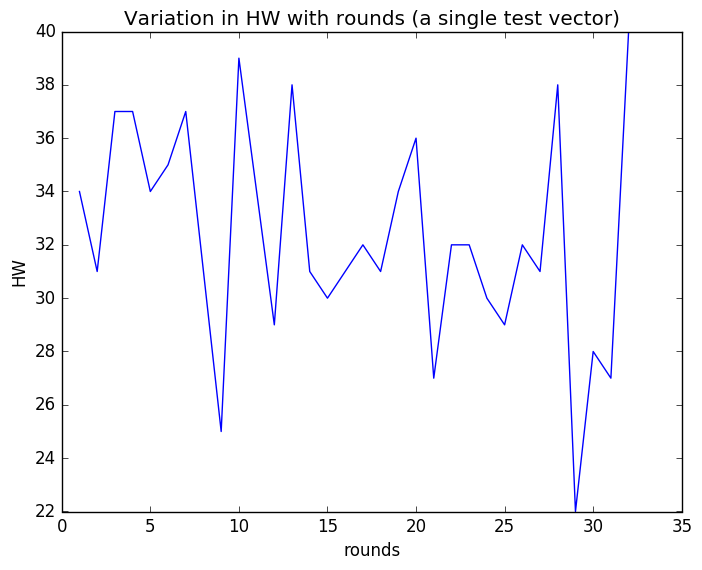

In [17]:
x = 1:1:32
#for a single random test vector
plt.plot(x,samples[1])
xlabel("rounds")
ylabel("HW")
title("Variation in HW with rounds (a single test vector)")
plt.savefig("single_testvector.png")

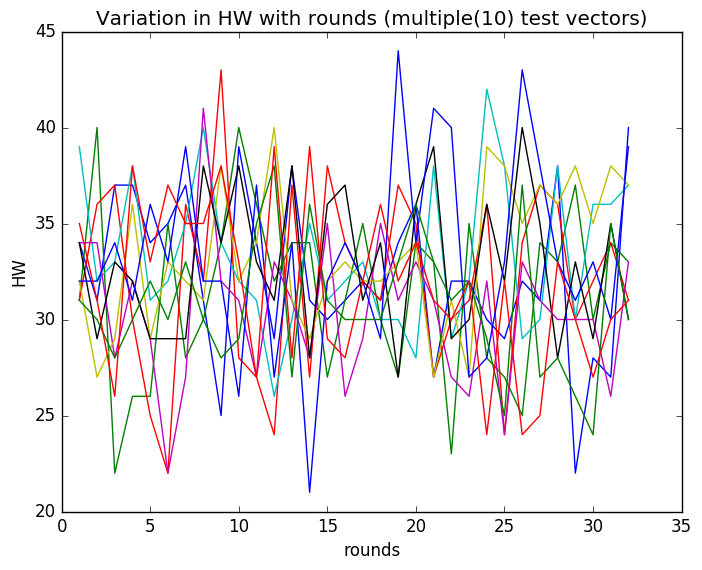

In [18]:
#now i need to plot all the sample collected in one single plot
#plotting for multiple testvector
for i in 1:10
    plt.plot(x,samples[i])
end
xlabel("rounds")
ylabel("HW")
title("Variation in HW with rounds (multiple(10) test vectors)")
plt.savefig("10_testvectors.png")

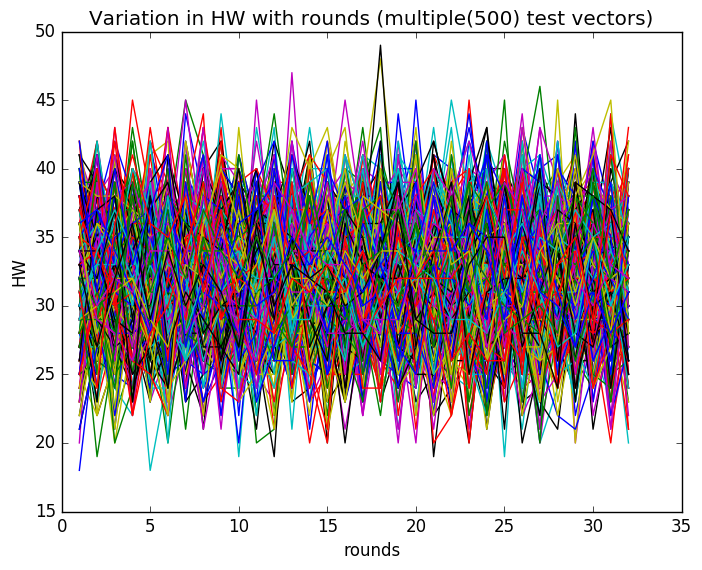

In [19]:
#plotting a large number of test vectors
for i in 1:500
    plt.plot(x,samples[i])
end
xlabel("rounds")
ylabel("HW")
title("Variation in HW with rounds (multiple(500) test vectors)")
plt.savefig("500_testvectors.png")

In [46]:
#I will do exhaustive search on 16 nibbles possible and using CPA figure out key at 1st round
#in practical application the master key won't be passed but a blackbox capable of producing the output
#nibble_n represents the nibble_number being cureently guessed

function nibble_guesser(nibble_n, master_key)
    n_testv = 5000 #number of test vectors generated per guess key
    all_nibbles = bit_permutation(4)
    guessResDict = Dict()
    refkey=""
    for gkey in all_nibbles
        hw_ref_data = fill(-1.0,n_testv)
        hw_smp_data = fill(-1.0,n_testv)
        #test for many input vectors
        for i in 1:n_testv
            testv = bin(r[:randint](0,15),4)
            
            #########the functionality of the black box epected####
            temp = repeat("0",4*(nibble_n-1))
            temp = join([temp,testv])
            temp = join([temp,repeat("0",64-4*nibble_n)])
            testv_pad = temp
            
            r_ref1 = PRESENT_encrypter(master_key, testv_pad)[1].outp
            ref1 = invP(r_ref1) #the output after the Slayer in the first round
            the_s_box_observed = ref1[(4*nibble_n)-3:4*nibble_n]
            N = rand(0:4) #the noise
            hw_ref_data[i] = HW(the_s_box_observed)+N
            #######################################################
            
            hw_smp_data[i] = HW(S_box[xor(testv,gkey)])
        end
        #calculate and store Correlation Coefficient for this guess
        guessResDict[gkey] = cor(hw_ref_data, hw_smp_data)
    end
    
    #choosing the one with largest absolute correlation value
    max = 0
    pred_k = ""
    for k in all_nibbles
        if abs(guessResDict[k]) > max
            max = abs(guessResDict[k])
            pred_k = k
        end
    end
    pred_k
    
    #plotting correlation coeff
    X = fill(0,16)
    Y = fill(-1.0,16)
    i=1
    for x in all_nibbles
        X[i] = i
        Y[i] = guessResDict[x]
        i = i+1
    end
    plt.plot(X,Y)
        
end

nibble_guesser (generic function with 1 method)

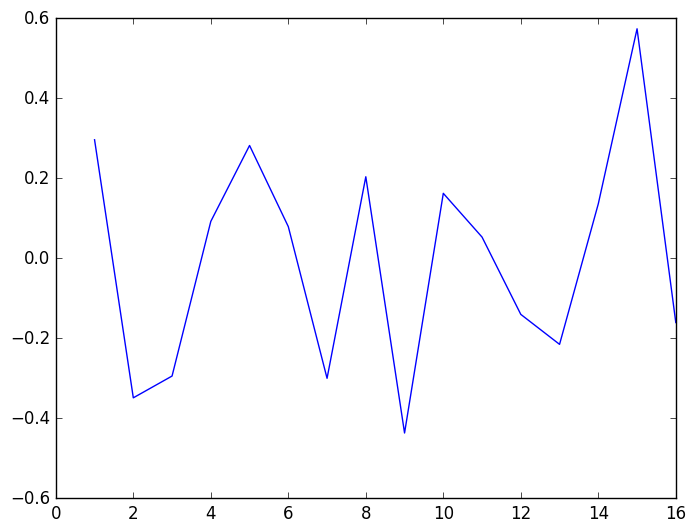

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f07850715d0>

In [47]:
nibble_guesser(2,bin(1234546555544,80))

In [35]:
r31key=""
for i in 1:16
    r31key = join([r31key,nibble_guesser(i,bin(5673492389,80))])
end
r31key

"1101010111000010011110100000111010111000011110000011101100111000"

In [36]:
println("guessed_nibbles","      ","original_nibble")
for i in 4:4:64
    println(r31key[i-3:i],"                   ",genKeys(bin(5673492389,80))[31][i-3:i])
end

guessed_nibbles      original_nibble
1101                   1101
0101                   0101
1100                   1100
0010                   0010
0111                   0111
1010                   1010
0000                   0000
1110                   1110
1011                   1011
1000                   1000
0111                   0111
1000                   1000
0011                   0011
1011                   1011
0011                   0011
1000                   1000


In [37]:
println("guessed_key","          ","real_key")
println(bin2hex(r31key),"     ",bin2hex(genKeys(bin(5673492389,80))[31]))

guessed_key          real_key
d5c27a0eb8783b38     d5c27a0eb8783b38


In [24]:
#for doing CPA the first rounds of many implementation are usually the most vulnerable
#assuming that our implementation is on microcontroller (and not not FPGA) the leakage 
#while loading the data to the S-box (HW model) is much more prominnent than updating the registers (HD model)
#hence we can expect the power trace to actually be governed by the HW model

#first round attack on the PRESENT cipher

function first_round_attack(black_box_master_key)
    guessed_key=""
    for i in 1:16
        g = nibble_guesser(i,black_box_master_key)
        println("The key nibble guessed for ", i, " box is: ", g)
        guessed_key = join([guessed_key,g])
    end
    println("The guessed key is: ", bin2hex(guessed_key))
end
    

first_round_attack (generic function with 1 method)

In [25]:
first_round_attack(bin(124589,80))

The key nibble guessed for 1 box is: 0000
The key nibble guessed for 2 box is: 0000
The key nibble guessed for 3 box is: 0000
The key nibble guessed for 4 box is: 0000
The key nibble guessed for 5 box is: 0000
The key nibble guessed for 6 box is: 0000
The key nibble guessed for 7 box is: 0000
The key nibble guessed for 8 box is: 0000
The key nibble guessed for 9 box is: 0000
The key nibble guessed for 10 box is: 0000
The key nibble guessed for 11 box is: 0000
The key nibble guessed for 12 box is: 0000
The key nibble guessed for 13 box is: 0000
The key nibble guessed for 14 box is: 0000
The key nibble guessed for 15 box is: 0000
The key nibble guessed for 16 box is: 0001
The guessed key is: 0000000000000001


In [ ]:
#An important point is I will get the power trace of all the rounds, In microcontroller model
#these power trace would correspond to the parts such as getting data to S-boxes and
#such power consumptions are better modelled by HW values of just before the S-box of each round

#CPA on last round(32) of PRESENT
#the idea is to generate the many random input testvectors, now I will know the ciphertext
#corresponding to each nibble from left hand side I will guess a nibble for the key
#then I have to tke xor with the guessed nibble then invP then 

In [26]:
bin(124589,80)

"00000000000000000000000000000000000000000000000000000000000000011110011010101101"

In [35]:
addprocs(4)

4-element Array{Int64,1}:
 6
 7
 8
 9

In [34]:
#trying to paprallelise the code
function multi_nibble_guesser(l,r,master_key)
    lr_key=""
    for i in l:r
        lr_key=join([lr_key, nibble_guesser(i,master_key)])
    end
    lr_key
end

multi_nibble_guesser (generic function with 1 method)

In [36]:
#since I have four cores i will spawn at 4 processes
mkey = bin(2334353455778342421234,80)
r1 = remotecall(multi_nibble_guesser,6,1,4,mkey)
r2 = remotecall(multi_nibble_guesser,7,5,8,mkey)
r3 = remotecall(multi_nibble_guesser,8,9,12,mkey)
r4 = remotecall(multi_nibble_guesser,9,13,16,mkey)

s = @spawn join([fetch(r1),fetch(r2),fetch(r3),fetch(r4)])

@time fetch(s)

LoadError: On worker 3:
On worker 6:
UndefVarError: #multi_nibble_guesser not defined
 in deserialize_datatype at ./serialize.jl:825
 in handle_deserialize at ./serialize.jl:571
 in deserialize_msg at ./multi.jl:120
 in message_handler_loop at ./multi.jl:1317
 in process_tcp_streams at ./multi.jl:1276
 in #638 at ./event.jl:68
 in #remotecall_fetch#626 at ./multi.jl:1070
 in remotecall_fetch at ./multi.jl:1062
 in #remotecall_fetch#629 at ./multi.jl:1080
 in remotecall_fetch at ./multi.jl:1080
 in call_on_owner at ./multi.jl:1130
 in fetch at ./multi.jl:1156
 in #6 at ./multi.jl:1904
 in #642 at ./multi.jl:1417
 in run_work_thunk at ./multi.jl:1001
 in run_work_thunk at ./multi.jl:1010 [inlined]
 in #617 at ./event.jl:68